In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from keras.models import load_model

import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
import cv2
import math
from google.colab.patches import cv2_imshow
#import torchvision.transforms.function as TF

Mounted at /content/drive


In [ ]:
detect_img_h = 480
detect_img_w = 640
action_low = np.array([-0.02, -0.02, -0.05, -15 * np.pi / 180])
action_high = np.array([0.02, 0.02, -0.03, 15 * np.pi / 180])

classification_path = '/content/drive/Shareddrives/Senior Thesis/pretrained_model.hdf5'
#classification_path_2 = '/content/drive/Shareddrives/Senior Thesis/my_model.hdf5'

blur = 5
minR = 20
maxR = 40
p1 = 50
p2 = 30
delta = 45

classify_img_h = 80
classify_img_w = 80


In [ ]:
from contextlib import nullcontext
def Hough(image, blur, p1, p2, minR, maxR):
    gray = image.astype('uint8')
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, blur)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT,1,gray.shape[0]/8, param1=p1,param2=p2,minRadius=minR,maxRadius=maxR)
    if circles is None:
      return None
    else:
      circles = np.uint16(np.around(circles))[0,:]
      return circles

In [ ]:
def map_to_space(v,w):
        
    theta = 0.0863 #radians
    x_off = 26/100 #m
    y_off = -32/100 #m
    h_pix = detect_img_h
    w_pix = detect_img_w
    width = 69.5/100 #m
    height = 52/100 #m

    rotation_mx = np.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]])
    scaling_mx = np.array([[height/h_pix, 0],[0, width/w_pix]])
    global_offset_mx = np.array([[x_off], [y_off]])
    camera_position = np.array([[v],[w]])

    global_position = rotation_mx@scaling_mx@camera_position + global_offset_mx

    return global_position

In [ ]:
classifier = load_model(classification_path)
#classifier_2 = load_model(classification_path_2)

[[0.04763446 0.9523655 ]]


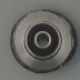

Action raw:  (array([0.54796565]), array([-0.17954733]), 0.1, 0)
[[0.00294714 0.9970529 ]]


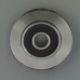

Action raw:  (array([0.53945384]), array([-0.05602441]), 0.1, 0)
[[0.9816095  0.01839055]]
[[5.3497683e-04 9.9946505e-01]]


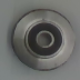

Action raw:  (array([0.53106463]), array([0.19176842]), 0.1, 0)


In [ ]:
image = cv2.imread('defect_snapshot_Color.png')
#image = image/255
#cv2_imshow(image)
data = Hough(image, blur, p1, p2, minR, maxR)
if data is None:
  print('No objects found')
  actino = (0.45,0,0.4,0) #the default initial pose
  print('Action: ', action)
else:
  centers = data[:,0:2]
  radii = data[:,-1]
  for i in range(len(centers)):
      height = radii[i] + delta
      y, x = centers[i,0] , centers[i,1]
      top, left = x-int(height/2), y-int(height/2)
      bottom, right = x+int(height/2), y+int(height/2)
      image_crop = image[top:bottom, left:right] 
      image_crop = cv2.resize(image_crop, (classify_img_h,classify_img_w))
      image_decide = image_crop[np.newaxis,:] # for classifier needing a batch size 
      decision = classifier.predict(image_decide)
      #decision_2 = classifier_2.predict(image_decide)
      print(decision)
      if np.argmax(decision) == 1:
          # find center of the object
          # convert to location from pixel value
          cv2_imshow(image_crop)
          coord = map_to_space(x,y)
          action =(coord[0], coord[1], 0.1, 0)
          print('Action raw: ', action)